In [6]:
import torch
import torchvision
import numpy as np

from benchmark import ImageBenchmark

In [7]:
bench = ImageBenchmark()
models = list(bench.list_models())
for i, model in enumerate(models):
    if not model.torch_model_exists():
        continue
    print(f'{i}\t {model.__str__()}')
#     if 'quantize' in model.__str__():
#         continue
#     acc = model.accuracy if model.dataset_id != 'ImageNet' else '-'
#     print(f'{i}\t {model.__str__()} {acc}')

0	 pretrain(mbnetv2,ImageNet)-
1	 pretrain(resnet18,ImageNet)-
2	 train(mbnetv2,Flower102)-
3	 train(mbnetv2,SDog120)-
4	 train(resnet18,Flower102)-
5	 train(resnet18,SDog120)-
6	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,0.1)-
7	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,0.5)-
8	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,1)-
9	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,0.1)-
10	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,0.5)-
11	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,1)-
12	 pretrain(resnet18,ImageNet)-transfer(Flower102,0.1)-
13	 pretrain(resnet18,ImageNet)-transfer(Flower102,0.5)-
14	 pretrain(resnet18,ImageNet)-transfer(Flower102,1)-
15	 pretrain(resnet18,ImageNet)-transfer(SDog120,0.1)-
16	 pretrain(resnet18,ImageNet)-transfer(SDog120,0.5)-
17	 pretrain(resnet18,ImageNet)-transfer(SDog120,1)-
18	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,0.1)-quantize(qint8)-
19	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,0.1)-quantize(float16)-
20	 pretrain(mbnetv2,Im

In [8]:
from modeldiff import ModelDiff

def compare_with_seed(model1, model2, truth=-1):
    print(f'comparing:\n  model1={model1}\n  model2={model2}')
    md = ModelDiff(model1, model2)
    seed_inputs = md.get_seed_inputs(rand=False)
    sim = md.compute_similarity_with_inputs(seed_inputs)
    if truth == -1:
        truth = 1 if model1.__str__().split('-')[0] == model2.__str__().split('-')[0] else 0
    print(f' similarity is {sim}, truth is {truth}')

def test(compare):
    compare(models[23], models[38], 1) # should be similar
    compare(models[1], models[0], 0)   # should be different
    compare(models[13], models[25], 0) # should be different
    compare(models[13], models[22], 0) # should be different
    compare(models[1], models[17], 1)  # should be similar
    compare(models[16], models[13], 1) # should be similar
    compare(models[13], models[12], 1) # should be similar
    
# test(compare_with_seed)

In [11]:
DEVICE = 'cpu'
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(name)-12s %(levelname)-8s %(message)s")


def gen_adv_inputs(model, inputs):
    from advertorch.attacks import LinfPGDAttack
    def myloss(yhat, y):
        return -((yhat[:,0]-y[:,0])**2 + 0.1*((yhat[:,1:]-y[:,1:])**2).mean(1)).mean()
        
    model = model.to(DEVICE)
    inputs = torch.from_numpy(inputs).to(DEVICE)
    with torch.no_grad():
        model.eval()
        clean_outputs = model(inputs)
    
    output_shape = clean_outputs.shape
    batch_size = output_shape[0]
    num_classes = output_shape[1]
    
    y = torch.zeros(size=output_shape).to(DEVICE)
    y[:, 0] = 1000
    # more diversity
#     rand_idx = torch.randint(low=0, high=num_classes, size=(batch_size,))
#     y = torch.nn.functional.one_hot(rand_idx, num_classes=num_classes).to(DEVICE) * 10
#     print(y)
    
    adversary = LinfPGDAttack(
        model, loss_fn=myloss, eps=0.1,
        nb_iter=40, eps_iter=0.01, 
        rand_init=True, clip_min=-2.2, clip_max=2.2,
        targeted=False
    )
    
    adv_inputs = adversary.perturb(inputs, y)
    
    with torch.no_grad():
        model.eval()
        adv_outputs = model(adv_inputs).to('cpu').numpy()
#     print(adv_outputs)
    torch.cuda.empty_cache()
    return adv_inputs.to('cpu').numpy()

def compare_with_adv(model1, model2, truth=-1):
    if truth == -1:
        truth = 1 if model1.__str__().split('-')[0] == model2.__str__().split('-')[0] else 0
    print(f'comparing:\n  model1={model1}\n  model2={model2}')
    md = ModelDiff(model1, model2)
    rand = False
    seed_inputs1 = model1.get_seed_inputs(100, rand=rand)
    seed_inputs2 = model2.get_seed_inputs(100, rand=rand)
    seed_inputs = np.concatenate([seed_inputs1, seed_inputs2])
    
    adv_inputs1 = gen_adv_inputs(model1.torch_model, seed_inputs1)
    adv_inputs2 = gen_adv_inputs(model2.torch_model, seed_inputs2)
    adv_inputs = np.concatenate([adv_inputs1, adv_inputs2])
    
#     adv_inputs_shuffle = list(adv_inputs)
#     np.random.shuffle(adv_inputs_shuffle)
#     adv_inputs_shuffle = np.array(adv_inputs_shuffle)
#     sim = md.compute_similarity_with_ddm(adv_inputs_shuffle)
#     print(f' compute_similarity_with_ddm,adv_inputs_shuffle is {sim}, truth is {truth}')

    hybrid_inputs = np.concatenate([seed_inputs1, adv_inputs1])
    
#     sim = md.compute_similarity_with_ddm(adv_inputs)
#     print(f' compute_similarity_with_ddm,adv_inputs is {sim}, truth is {truth}')
#     sim = md.compute_similarity_with_ddm(seed_inputs)
#     print(f' compute_similarity_with_ddm,seed_inputs is {sim}, truth is {truth}')
#     sim = md.compute_similarity_with_ddm(hybrid_inputs)
#     print(f' compute_similarity_with_ddm,hybrid_inputs is {sim}, truth is {truth}')
    
    sim = md.compute_similarity_with_ddv(adv_inputs)
    print(f' compute_similarity_with_ddv,adv_inputs is {sim}, truth is {truth}')
    sim = md.compute_similarity_with_ddv(seed_inputs)
    print(f' compute_similarity_with_ddv,seed_inputs is {sim}, truth is {truth}')
    sim = md.compute_similarity_with_ddv(hybrid_inputs)
    print(f' compute_similarity_with_ddv,hybrid_inputs is {sim}, truth is {truth}')
    
#     ddv_clean = md.compute_ddv(model1, seed_inputs)
#     ddv_adv = md.compute_ddv(model1, adv_inputs)
#     ddv_advshuf = md.compute_ddv(model1, adv_inputs_shuffle)
#     print(f' ddv_clean={ddv_clean}\n ddv_adv={ddv_adv}\n ddv_advshuf={ddv_advshuf}')
    
#     batch_outputs1 = model1.batch_forward(adv_inputs)
#     _, batch_preds1 = batch_outputs1.to('cpu').data.max(1)
#     batch_outputs2 = model2.batch_forward(adv_inputs)
#     _, batch_preds2 = batch_outputs2.to('cpu').data.max(1)
#     print(f'  batch_preds1={batch_preds1}\n  batch_preds2={batch_preds2}')


# compare_with_adv(models[1], models[17], 1)
test(compare_with_adv)

2020-08-24 05:20:07,322 ModelDiff    INFO     comparing pretrain(mbnetv2,ImageNet)-transfer(Flower102,1)-quantize(float16)- and pretrain(resnet18,ImageNet)-transfer(SDog120,0.5)-quantize(qint8)-


comparing:
  model1=pretrain(mbnetv2,ImageNet)-transfer(Flower102,1)-quantize(float16)-
  model2=pretrain(resnet18,ImageNet)-transfer(SDog120,0.5)-quantize(qint8)-


AttributeError: 'NoneType' object has no attribute 'data'

In [4]:
from utils import Utils
from matplotlib import pyplot as plt

def show_images(images, labels, title='examples'):
    images = np.transpose(images, (0, 2, 3, 1))
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(hspace=0.2)
    for n in range(25):
        plt.subplot(5,5,n+1)
        img = images[n]
        img = img.squeeze()
        plt.imshow(img)
        plt.title(f'{labels[n]}')
        plt.axis('off')
    _ = plt.suptitle(title)
    plt.show()

# show_images(seed_inputs, list(range(seed_inputs.shape[0])))
# print(seed_inputs[0])
# batch_outputs1 = model1.batch_forward(seed_inputs)
# batch_preds1 = batch_outputs1.to('cpu').data.max(1)
# print(batch_preds1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.6490, -1.4386,  2.5033,  1.8412,  4.8021, -1.6310,  2.0566,  1.5600,
         1.5116,  2.3608,  5.3255, -2.8754,  0.4178,  0.5488, -1.9436, -1.9866,
        -0.9769, -1.5207,  6.7899, -2.8750,  2.4132, -4.4044,  0.9417,  0.8590,
         2.2620,  0.4183,  1.9129, -1.2129, -1.1264,  5.0089, -2.5337, -2.1524,
        -3.0799, -0.9707, -2.1867, -1.0654,  0.1078, -0.9116, -2.0719, -1.7505,
         2.9943, -0.9800, -0.4358, -1.1629, -0.8991,  1.4888,  2.7156, -2.6192,
        -1.6224,  1.0777, -1.4695,  0.6036,  1.6370, -1.8419,  0.7619, -1.3229,
        -1.6419, -1.3410,  0.2290, -0.7731,  2.2141, -1.1059, -0.6040,  0.8259,
        -2.9979,  1.0821,  0.9092], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

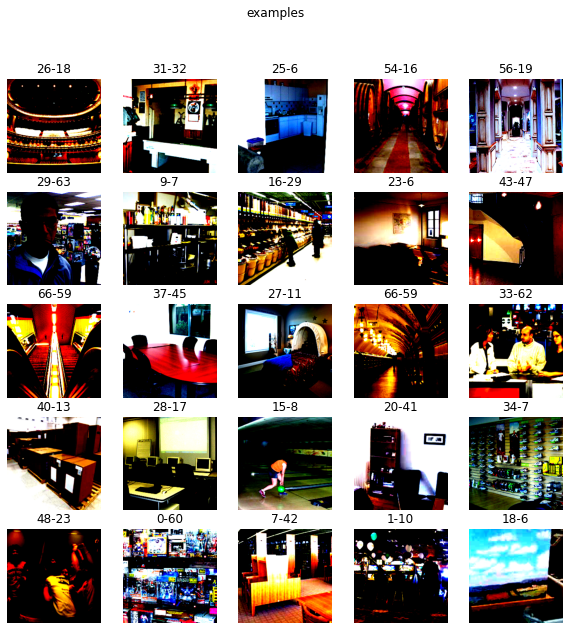

In [6]:
m = models[2]
mm = m.torch_model
test_loader = m.benchmark.get_dataloader(m.dataset_id, split='test')

# with torch.no_grad():
#     mm.eval()
#     total = 0
#     top1 = 0
#     for i, (batch, label) in enumerate(test_loader):
#         batch, label = batch.to(DEVICE), label.to(DEVICE)
#         total += batch.size(0)
#         out = mm(batch)
#         _, pred = out.max(dim=1)
#         top1 += int(pred.eq(label).sum().item())

# acc = float(top1) / total * 100
# print(top1, total, acc)

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i != 10:
            continue
        images, labels = images.cuda(), labels.cuda()
        outputs = mm(images)
        _, preds = outputs.max(dim=1)
        print(outputs[0])
        labels = [f'{label}-{preds[i]}' for i,label in enumerate(list(labels))]
        show_images(images.to('cpu').numpy(), labels)
        break

In [ ]:
from model.fe_mobilenet import mbnetv2_dropout
import os

torch_model = mbnetv2_dropout(
            pretrained=False,
            num_classes=67
        )
ckpt = torch.load(os.path.join('models', 'train(mbnetv2,MIT67)-', 'ckpt.pth'))
torch_model.load_state_dict(ckpt['state_dict'])
mm = torch_model

In [ ]:
import torch
import torchvision
import numpy as np

from benchmark import ImageBenchmark
bench = ImageBenchmark()
models = list(bench.list_models())
for i, model in enumerate(models):
    if not model.torch_model_exists():
        continue
    if 'quantize' in model.__str__():
        continue
    acc = model.accuracy if model.dataset_id != 'ImageNet' else '-'
    print(f'{i}\t {model.__str__()} {acc}')

0	 pretrain(mbnetv2,ImageNet)- -
1	 pretrain(resnet18,ImageNet)- -
2	 train(mbnetv2,MIT67)- 1.4179104477611941
3	 train(mbnetv2,Flower102)- 70.48300536672629
4	 train(mbnetv2,SDog120)- 56.2004662004662
5	 train(resnet18,MIT67)- 1.4179104477611941
6	 train(resnet18,Flower102)- 70.54805659456822
7	 train(resnet18,SDog120)- 59.12587412587412
8	 pretrain(mbnetv2,ImageNet)-transfer(MIT67,0.1)- 1.7164179104477613
9	 pretrain(mbnetv2,ImageNet)-transfer(MIT67,0.5)- 1.8656716417910446
10	 pretrain(mbnetv2,ImageNet)-transfer(MIT67,1)- 2.014925373134328
11	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,0.1)- 94.16165230118719
12	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,0.5)- 95.52772808586762
13	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,1)- 95.56025369978859
14	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,0.1)- 81.36363636363636
15	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,0.5)- 80.71095571095572
16	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,1)- 80.48951048951048
17	 pretrain(resn

In [1]:
import torch
import torchvision
import numpy as np

from benchmark import ImageBenchmark
bench = ImageBenchmark()
models = list(bench.list_models())
for i, model in enumerate(models):
    if not model.torch_model_exists():
        continue
    if 'quantize' in model.__str__():
        continue
    acc = model.accuracy if model.dataset_id != 'ImageNet' else '-'
    print(f'{i}\t {model.__str__()} {acc}')

0	 pretrain(mbnetv2,ImageNet)- -
1	 pretrain(resnet18,ImageNet)- -
2	 train(mbnetv2,Flower102)- 70.48300536672629
3	 train(mbnetv2,SDog120)- 56.2004662004662
4	 train(resnet18,Flower102)- 70.54805659456822
5	 train(resnet18,SDog120)- 59.12587412587412
6	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,0.1)- 94.16165230118719
7	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,0.5)- 95.52772808586762
8	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,1)- 95.56025369978859
9	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,0.1)- 81.36363636363636
10	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,0.5)- 80.71095571095572
11	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,1)- 80.48951048951048
12	 pretrain(resnet18,ImageNet)-transfer(Flower102,0.1)- 92.0474873963246
13	 pretrain(resnet18,ImageNet)-transfer(Flower102,0.5)- 95.07236949097414
14	 pretrain(resnet18,ImageNet)-transfer(Flower102,1)- 94.99105545617174
15	 pretrain(resnet18,ImageNet)-transfer(SDog120,0.1)- 81.35198135198135
16	 pretrain(resnet18,I

In [7]:
bench.models_dir = 'models_benchmark'

In [3]:
import os
import shutil
import numpy as np
from benchmark import ImageBenchmark

bench = ImageBenchmark()
models = list(bench.list_models())
for i,model in enumerate(models):
    if model.__str__().startswith('train') and 'MIT67' not in model.__str__():
        model_path = os.path.join(model.torch_model_path, 'final_ckpt.pth')
#         acc = model.accuracy if model.dataset_id != 'ImageNet' else '-'
#         print(f'{i}\t {model.__str__()} {acc}')
        new_model_dir = model.torch_model_path.replace('models', 'models_retrain')
        new_model_path = os.path.join(new_model_dir, 'final_ckpt.pth')
        print(new_model_path)
        os.makedirs(new_model_dir)
        shutil.copyfile(model_path, new_model_path)

models_retrain/train(mbnetv2,Flower102)-/final_ckpt.pth
models_retrain/train(mbnetv2,SDog120)-/final_ckpt.pth
models_retrain/train(resnet18,Flower102)-/final_ckpt.pth
models_retrain/train(resnet18,SDog120)-/final_ckpt.pth
models_retrain/train(mbnetv2,Flower102)-prune(0.2)-/final_ckpt.pth
models_retrain/train(mbnetv2,Flower102)-prune(0.5)-/final_ckpt.pth
models_retrain/train(mbnetv2,Flower102)-prune(0.8)-/final_ckpt.pth
models_retrain/train(mbnetv2,SDog120)-prune(0.2)-/final_ckpt.pth
models_retrain/train(mbnetv2,SDog120)-prune(0.5)-/final_ckpt.pth
models_retrain/train(mbnetv2,SDog120)-prune(0.8)-/final_ckpt.pth
models_retrain/train(resnet18,Flower102)-prune(0.2)-/final_ckpt.pth
models_retrain/train(resnet18,Flower102)-prune(0.5)-/final_ckpt.pth
models_retrain/train(resnet18,Flower102)-prune(0.8)-/final_ckpt.pth
models_retrain/train(resnet18,SDog120)-prune(0.2)-/final_ckpt.pth
models_retrain/train(resnet18,SDog120)-prune(0.5)-/final_ckpt.pth
models_retrain/train(resnet18,SDog120)-prune(0